In [1]:
# This disables SSL certificate verification for the current session which enable us
# to download the MNIST dataset without any problem.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Import of custom functions
from specific_sample_unlearning import selective_train_unlearning
from plot_generator import plot_accuracy, plot_loss, plot_confusion_matrix, plot_pca
from utils import adjust_class_representation, check_class_distribution

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('./data', train=True, download=True, transform=transform)
test_dataset = MNIST('./data', train=False, transform=transform)

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Create Imbalanced dataset with the overrepresentation of the class 6

In [4]:
#If i > 1, it performs overrepresentation. If 0 < i < 1, it performs underrepresentation
adjusted_train_dataset = adjust_class_representation(train_dataset, class_to_adjust=6, i=2, reduce_to=100, duplication_factor=10)

# Check the class distribution in the underrepresented dataset
check_class_distribution(adjusted_train_dataset)

# Create a dataloader from the adjusted dataset
train_loader = DataLoader(adjusted_train_dataset, batch_size=64, shuffle=True)

Overrepresenting class 6 by a factor of 10
Class distribution: Counter({6: 59180, 1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 8: 5851, 4: 5842, 5: 5421})


In [5]:
# Here we can find the implementation of the custom the model
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super(CustomNeuralNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2x2, stride 2
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # First conv + relu + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second conv + relu + pooling
        
        # Flatten the output of the conv layers
        x = x.view(-1, 64 * 7 * 7)  # Reshape for the fully connected layers
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# Initialize model, loss, and optimizer
model = CustomNeuralNetwork()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [8]:
# Variables to store accuracy and loss for info graphs 
train_acc = []
unlearn_acc = []
train_loss = []
unlearn_loss = []
epochs = list(range(1, 4))

In [9]:
# Train model on the dataset
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    correct = 0
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader.dataset)
    train_acc.append(accuracy)
    train_loss.append(avg_loss)
    print(f"Train Epoch: {epoch} Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

In [10]:
# Test model performance
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    y_pred = []  # To store all predictions
    y_true = []  # To store all true labels        
        
    with torch.no_grad():  # Here we disable gradient calculation for inference
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()  # Add batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            y_pred.extend(pred.view(-1).tolist())  # Store predictions, flatten tensor and convert to list
            y_true.extend(target.view(-1).tolist())  # Store true labels, flatten tensor and convert to list
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions
    
    test_loss /= len(test_loader.dataset)  # Average loss per sample
    accuracy = 100. * correct / len(test_loader.dataset)  # Compute accuracy
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return accuracy, y_pred, y_true

In [11]:
# Train the model on the entire dataset first
for epoch in epochs: 
    train(model, train_loader, criterion, optimizer, epoch)

Train Epoch: 1 Accuracy: 97.13%, Loss: 0.0014
Train Epoch: 2 Accuracy: 99.18%, Loss: 0.0004
Train Epoch: 3 Accuracy: 99.43%, Loss: 0.0003


In [12]:
# Test the model before unlearning
print("Testing pre-trained model:")
train_accuracy_before, y_pred_before, y_true_before = test(model, test_loader)

Testing pre-trained model:

Test set: Average loss: 0.0000, Accuracy: 9857/10000 (98.57%)



In [13]:
# Now for unlearning class 6 and learning class 3
# we freeze all weights except for the final layer
for param in model.fc1.parameters():
    param.requires_grad = False
for param in model.fc2.parameters():
    param.requires_grad = False

In [14]:
# Train with selective specific sample unlearning 
for epoch in epochs:
    selective_train_unlearning(model, train_loader, optimizer, criterion, epoch, unlearn_acc, unlearn_loss)

Selective Unlearning Epoch: 1 Accuracy: 46.73%, Loss: 0.0727
Selective Unlearning Epoch: 2 Accuracy: 47.27%, Loss: 0.0165
Selective Unlearning Epoch: 3 Accuracy: 47.39%, Loss: 0.0120


In [15]:
# Test the model after unlearning
print("Testing model after unlearning:")
unlearn_accuracy_after, y_pred_after, y_true_after = test(model, test_loader)

Testing model after unlearning:

Test set: Average loss: 0.0012, Accuracy: 8936/10000 (89.36%)



In [16]:
def compute_class_accuracy(y_true, y_pred, target_class):
    # Convert to tensors if necessary
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # Get only the indices where the target class is in the ground truth
    target_indices = (y_true == target_class)
    
    # Calculate accuracy for that class
    correct_predictions = (y_true[target_indices] == y_pred[target_indices]).sum().item()
    total_predictions = target_indices.sum().item()
    
    if total_predictions == 0:
        return 0  # If there are no samples of this class
    return correct_predictions / total_predictions * 100

y_true_before = y_true_before.clone().detach() if isinstance(y_true_before, torch.Tensor) else torch.tensor(y_true_before)
y_pred_before = y_pred_before.clone().detach() if isinstance(y_pred_before, torch.Tensor) else torch.tensor(y_pred_before)
y_true_after = y_true_after.clone().detach() if isinstance(y_true_after, torch.Tensor) else torch.tensor(y_true_after)
y_pred_after = y_pred_after.clone().detach() if isinstance(y_pred_after, torch.Tensor) else torch.tensor(y_pred_after)

# Compute overall accuracy before and after unlearning
overall_accuracy_before = (y_true_before == y_pred_before).float().sum().item() / len(y_true_before) * 100
overall_accuracy_after = (y_true_after == y_pred_after).float().sum().item() / len(y_true_after) * 100

# Compute class 3 and class 6 accuracy before and after unlearning
class_3_accuracy_before = compute_class_accuracy(y_true_before, y_pred_before, target_class=3)
class_3_accuracy_after = compute_class_accuracy(y_true_after, y_pred_after, target_class=3)

class_6_accuracy_before = compute_class_accuracy(y_true_before, y_pred_before, target_class=6)
class_6_accuracy_after = compute_class_accuracy(y_true_after, y_pred_after, target_class=6)

# Print the results
print(f"Overall Accuracy Before Unlearning: {overall_accuracy_before:.2f}%")
print(f"Overall Accuracy After Unlearning: {overall_accuracy_after:.2f}%")

print(f"Class 3 Accuracy Before Unlearning: {class_3_accuracy_before:.2f}%")
print(f"Class 3 Accuracy After Unlearning: {class_3_accuracy_after:.2f}%")

print(f"Class 6 Accuracy Before Unlearning: {class_6_accuracy_before:.2f}%")
print(f"Class 6 Accuracy After Unlearning: {class_6_accuracy_after:.2f}%")

Overall Accuracy Before Unlearning: 98.57%
Overall Accuracy After Unlearning: 89.36%
Class 3 Accuracy Before Unlearning: 97.43%
Class 3 Accuracy After Unlearning: 99.01%
Class 6 Accuracy Before Unlearning: 99.27%
Class 6 Accuracy After Unlearning: 0.00%


/var/folders/wf/v6kvyp_x0qs8lhlcxvjc8p440000gn/T/ipykernel_15981/2527274937.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)
/var/folders/wf/v6kvyp_x0qs8lhlcxvjc8p440000gn/T/ipykernel_15981/2527274937.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred)


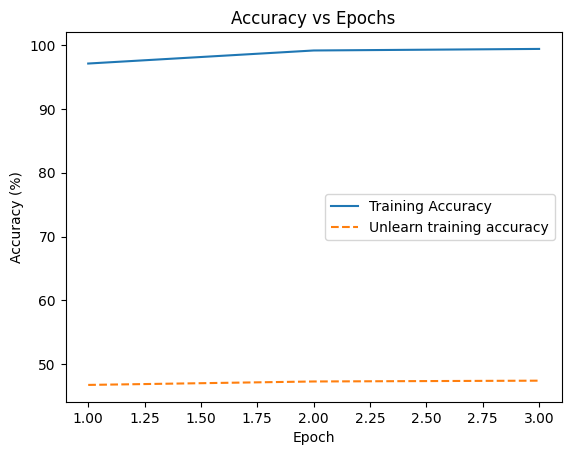

In [17]:
# Accuracy vs Epochs
plot_accuracy(train_acc, unlearn_acc, epochs)

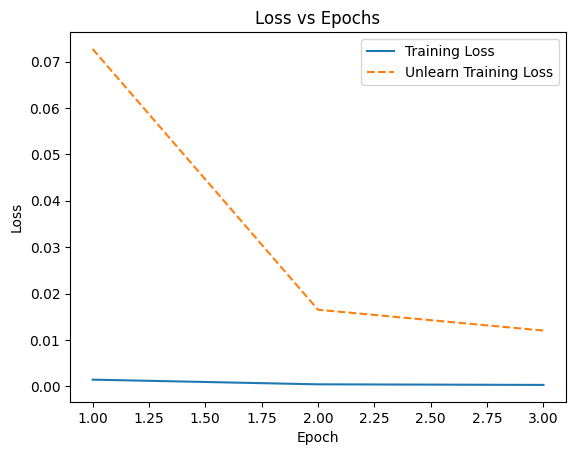

In [18]:
# Loss vs Epochs
plot_loss(train_loss, unlearn_loss, epochs)

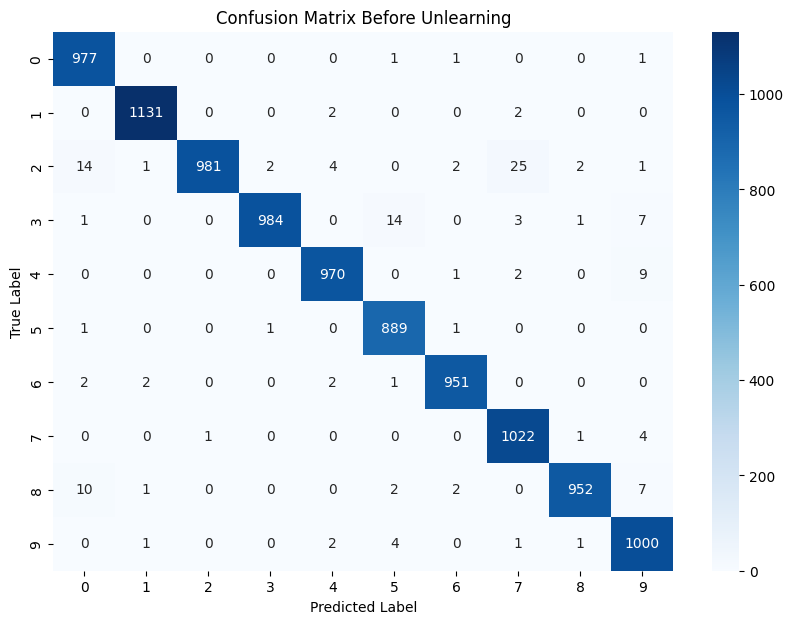

In [19]:
# Collect predictions and plot confusion matrix BEFORE unlearning
plot_confusion_matrix(y_true_before, y_pred_before, title="Confusion Matrix Before Unlearning")

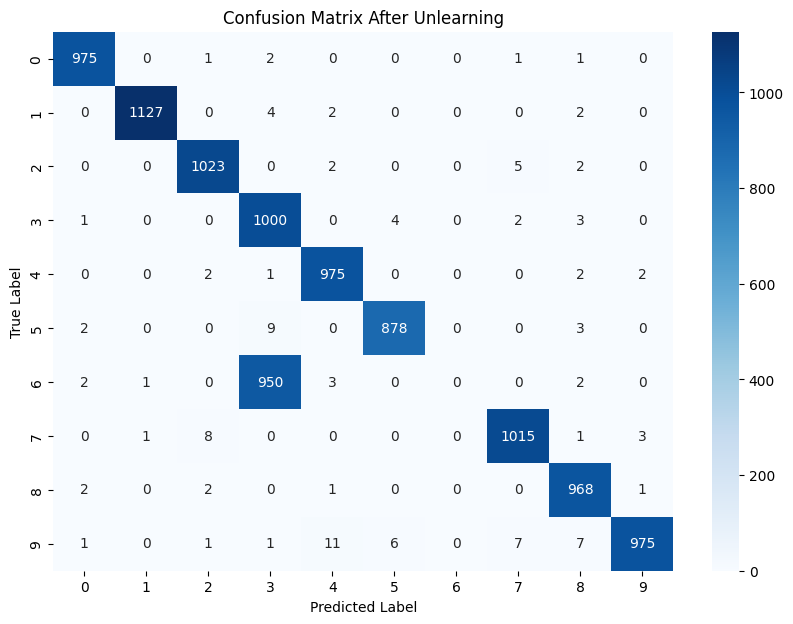

In [20]:
plot_confusion_matrix(y_true_after, y_pred_after, title="Confusion Matrix After Unlearning")